In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tqdm import tqdm
import os
import math

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
def show_image(img):
    imPlot1 = img[:,:,::-1]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.rcParams["figure.figsize"] = (25, 9)
    plt.imshow(imPlot1)
    
def show_gimage(img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap='gray')
    
def plotTwo(img1, img2):
    imPlot1 = img1[:,:,::-1]
    imPlot2 = img2[:,:,::-1]

    width, height = imPlot1.shape[:2]

    fig = plt.figure(figsize=(width/10, height/10))

    columns = 2
    rows = 1

    fig.add_subplot(rows, columns, 1)
    plt.imshow(imPlot1)

    fig.add_subplot(rows, columns, 2)
    plt.imshow(imPlot2)
    
    plt.show()

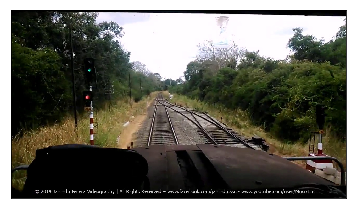

In [4]:
img = cv.imread('../images/video-x/frame24.jpg'); black_thresh = 7
#img = cv.imread('../images/video-x/frame223.jpg'); black_thresh = 7

#img = cv.imread('../images/video-4/frame254.jpg'); black_thresh = 30
#img = cv.imread('../images/night-1/frame90.jpg'); black_thresh = 30

#img = cv.imread('../images/video-1/frame203.jpg'); black_thresh = 56


show_image(img)

(720, 1280, 3)


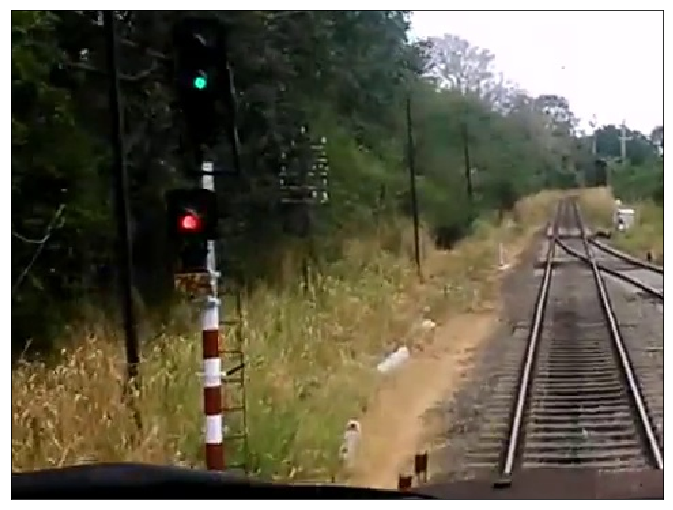

In [5]:
# Take only left
h,w,c = img.shape
print(img.shape)
cropped_img = img[math.floor(h/4):math.floor(h*3/4)]
cropped_img = cropped_img[:,math.floor(w/8):math.floor(w/2)]
cr_h,cr_w,_ = cropped_img.shape

show_image(cropped_img)

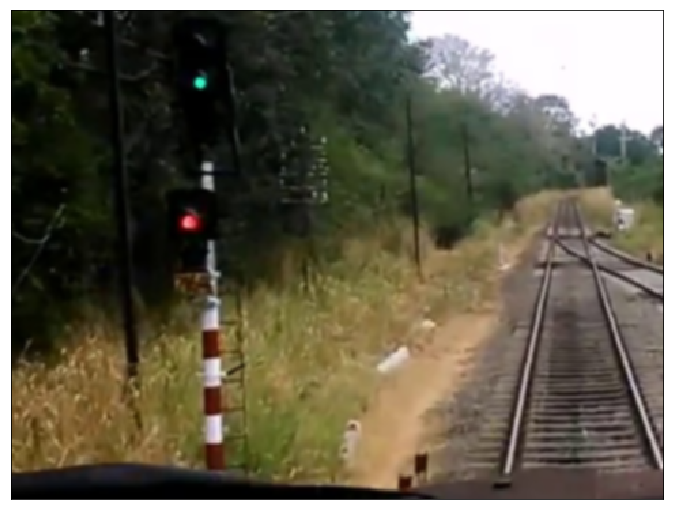

In [6]:
# Apply gaussian Blur
blured = cv.GaussianBlur(cropped_img, (5,5),0 )
show_image(blured)

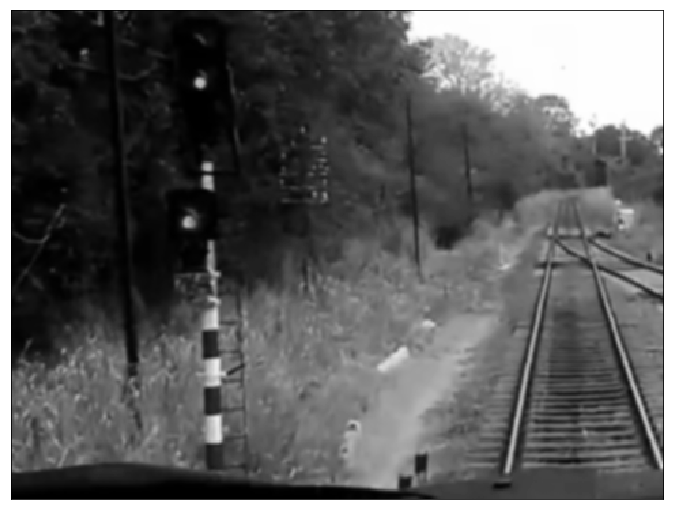

In [7]:
gray = cv.cvtColor(blured, cv.COLOR_BGR2GRAY)
show_gimage(gray)


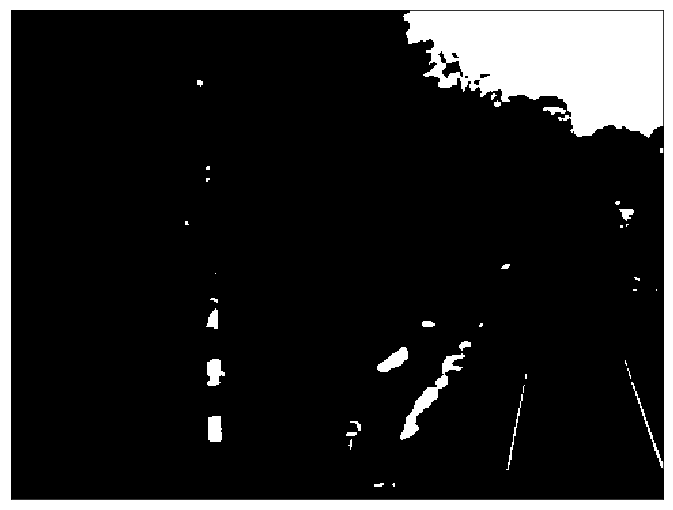

In [8]:
ret, gb = cv.threshold(gray,170,255,cv.THRESH_BINARY)

#gb = cv.bitwise_not(gb)
show_gimage(gb)

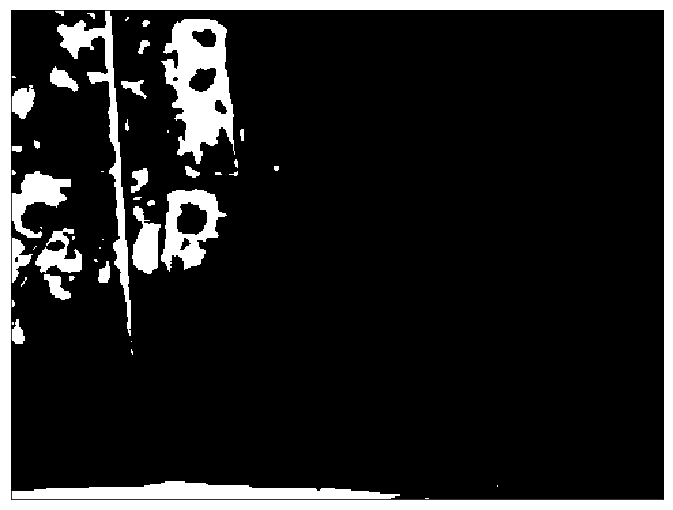

In [9]:
ret, black_shape = cv.threshold(gray,black_thresh,255,cv.THRESH_BINARY_INV)

#gb = cv.bitwise_not(gb)
show_gimage(black_shape)

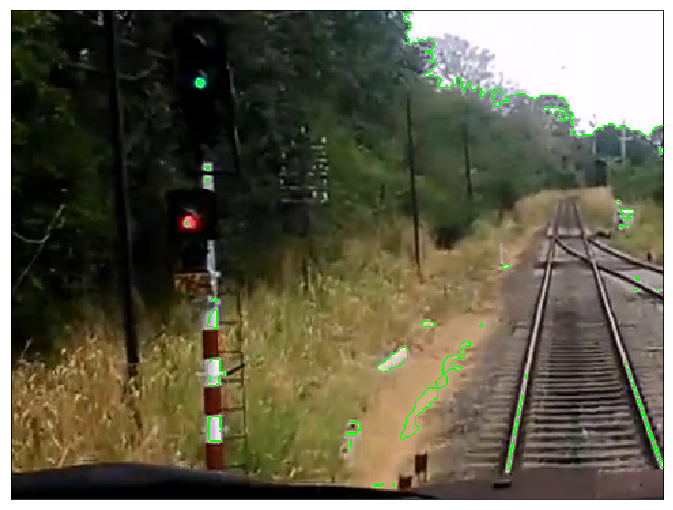

In [10]:
def draw(img, org):
    sky = org.copy()
    contours,hierachy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    rects = []   
    if len(contours) != 0:
        cv.drawContours(sky, contours, -1, (0,255,0), 1)
    show_image(sky) 
    
draw(gb, cropped_img)

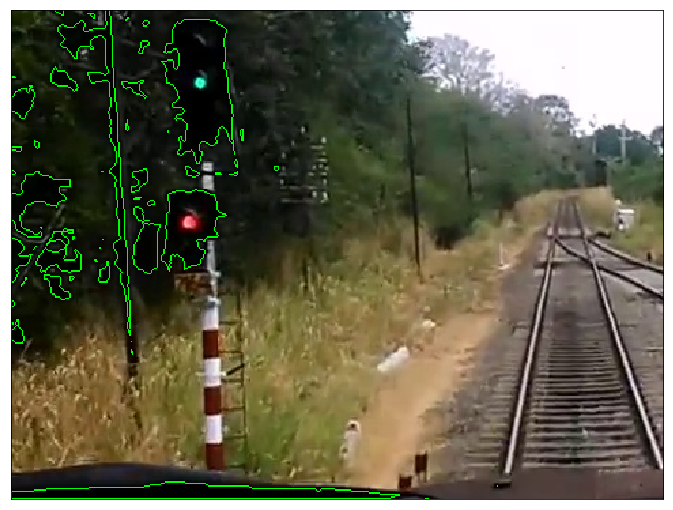

In [11]:
draw(black_shape, cropped_img)

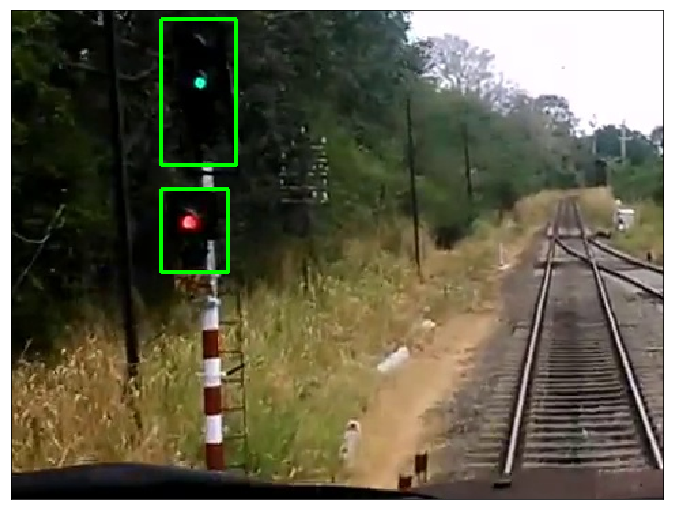

In [12]:
def find_lghts(light, black, org):
    contours_light,_ = cv.findContours(light, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    contours_black,_ = cv.findContours(black, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    thresh_height = cr_h/2
    thresh_width = cr_w/4
    trafic_lights = []
    rects = []
    for _, c in enumerate(contours_black):
        area_black = cv.contourArea(c)    
        if area_black > 0:
            #print(area_black)
            x,y,w,h = cv.boundingRect(c)      
            if w < thresh_width and h < thresh_height:
                for _, cl in enumerate(contours_light):
                    area_light = cv.contourArea(cl)             
                    if area_light > 0 and area_black > area_light:                
                        xl,yl,wl,hl = cv.boundingRect(cl)
                        if (x < xl and x+w > xl+ wl and y < yl and y+h > yl+hl):
                            trafic_lights.append(c)
                            rects.append(org[y:y+h,x:x+w])
                            break
    output = org.copy()
    for c in trafic_lights:    
        x,y,w,h = cv.boundingRect(c)
        cv.rectangle(output, (x,y), (x+w, y+h), (0,255,0),2)        
    return (output,rects)

output,rects = find_lghts(gb,black_shape,cropped_img)
show_image(output)

In [13]:
print(len(rects))

2


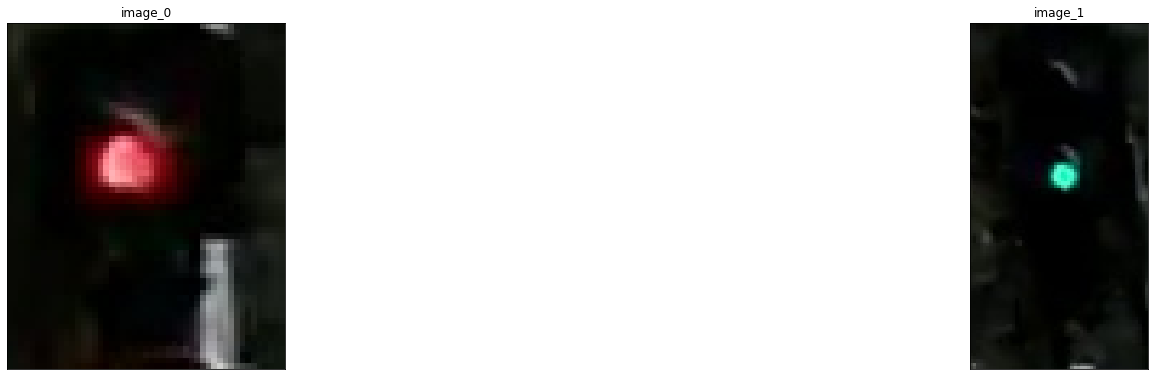

In [14]:
fig =plt.figure(figsize=(30,14))
plot_cols = 2
plot_rows = len(rects)/plot_cols+1
for cnt, img in enumerate(rects):
    y = fig.add_subplot(plot_rows,plot_cols, cnt+1)   
    imPlot1 = img[:,:,::-1]
    y.imshow(imPlot1)
    plt.title( 'image_' + str(cnt))
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)  